## Thompson Samplingの実験

In [14]:
from __future__ import division
import scipy.stats
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

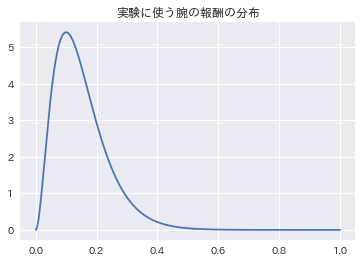

In [16]:
reward_gamma_shape = 3
def plot_reward_dist():
    x = np.linspace(0, 1, 1000)
    y = scipy.stats.gamma.pdf(x, reward_gamma_shape, scale=0.05)
    sns.plt.title(u'実験に使う腕の報酬の分布')
    sns.plt.plot(x, y)
    
plot_reward_dist()

In [217]:
#plt.hist(np.random.gamma(reward_gamma_shape, 0.05, size=10000), bins=100)
#plt.xlim(0, 1)

## 腕の実装

期待報酬に基づいて1 or 0を返すベルヌーイ腕

In [24]:
class MortalArm(object):
    def __init__(self, index, reward):
        self.index = index
        self.reward = reward
        self.is_live = True
        self.is_new = True
        self.pulled_count = 0
        
    def pull(self):
        if not self.is_live:
            raise RuntimeError('Already dead')
            
        self.is_new = False
        self.pulled_count += 1
        return 1 if np.random.random() < self.reward else 0
    
    def die(self):
        self.is_live = False

腕全体で生存期間パラメータを持ち、幾何分布に基づいて死ぬ

In [29]:
class MortalArms(object):
    # 報酬の生成関数 F(mu)を作ったのと同じ分布をつかう
    reward_fn = lambda self: max(0, np.random.gamma(reward_gamma_shape, 0.05))
    
    def __init__(self, init_size, lifetime_param):
        self.lifetime_param = lifetime_param        
        
        self._arms = []
        self.spawn_arms(init_size)
        
    def update(self):
        dead_count = 0
        for arm in list(filter(lambda a: a.is_live, self._arms)):
            # 生存パラメータpを使って腕を死なせる
            if np.random.random() < self.lifetime_param:
                arm.die()
                dead_count += 1
        
        # 減った分だけ新しく追加
        self.spawn_arms(dead_count)
                        
    def spawn_arms(self, num=1):
        for _ in range(num):
            index = len(self._arms)
            self._arms.append(MortalArm(index, self.reward_fn()))
    
    @property
    def living_arms(self):
        return list(filter(lambda a: a.is_live, self._arms))
    
    def select(self, i):
        return self._arms[i]
    
    def select_new_one(self):
        new_arms = list(filter(lambda a: a.is_new and a.is_live, self._arms))
        if new_arms:
            return new_arms[np.random.randint(len(new_arms))]
        return None

In [30]:
class ThompsonSamplingStrategy(object):
    def __init__(self, alpha, beta, with_stop=False, p=0.01, arms=100):
        self.arms = MortalArms(arms, p)
        self.arm_alpha = defaultdict(int) # Click       に相当
        self.arm_beta = defaultdict(int)  # IMP - Click に相当
        self.alpha = alpha
        self.beta = beta
        self.with_stop = with_stop
        
        # 実験用
        self.reward_history = []
            
    def pull(self):
        self.arms.update()
        
        theta = []
        for arm in self.arms.living_arms:
            if self.with_stop:
                # alpha, betaが大きくなり分散が小くなりすぎるのを防ぐ
                alpha = int(np.log(self.arm_alpha[arm.index] + 1)) + self.alpha
                beta = int(np.log(self.arm_beta[arm.index] + 1)) + self.beta
            else:
                alpha = self.arm_alpha[arm.index] + self.alpha
                beta = self.arm_beta[arm.index] + self.beta


            theta.append((arm, np.random.beta(alpha, beta)))
            
        arm, p_max = sorted(theta, key=lambda x:x[1])[-1]
              
        reward = arm.pull()
        if reward == 1:
            self.arm_alpha[arm.index] += 1
        else:
            self.arm_beta[arm.index] += 1
            
        self.reward_history.append(arm.reward)
        return reward

In [31]:
class UCB1Strategy(object):
    def __init__(self, p=0.01, arms=100, c=1):
        self.arms = MortalArms(arms, p)
        self.pulled_count = defaultdict(int)
        self.reward = defaultdict(int)
        
        # 実験結果確認用
        self.reward_history = []
        
    def select_arm(self):
        arm = self.arms.select_new_one()
        if arm:
            return arm
        
        living_arms = self.arms.living_arms
        
        pull_counts = []
        arm_indexes = []
        for k in list(filter(lambda i: self.arms.select(i).is_live, self.pulled_count.keys())):
            pull_counts.append(self.pulled_count[k])
            arm_indexes.append(k)
        
        ucb_vals = []
        total_pull = sum(pull_counts)
        for i in arm_indexes:
            bonus = np.sqrt((2 * np.log(total_pull)) / self.pulled_count[i])
            estimate_reward = self.reward[i]/self.pulled_count[i]
            ucb_vals.append(estimate_reward + bonus)
            
        return self.arms.select(arm_indexes[ucb_vals.index(max(ucb_vals))])
            
    def pull(self):
        self.arms.update()
        arm = self.select_arm()
        reward = arm.pull()
        self.pulled_count[arm.index] +=1
        self.reward[arm.index] += reward
        self.reward_history.append(arm.reward)
        return reward

## テスト

In [32]:
#施行回数
tests = 10000
#armの数
arms = 50
#パラメータ
alpha, beta = (1, 1)
strategy = ThompsonSamplingStrategy(alpha, beta, p=0.0001, arms=arms)
print('Start Thompson Samplig using alpha: %i, beta: %i' % (alpha, beta))
rewards1 = np.array([strategy.pull() for _ in range(tests)])
reward_ans1 = strategy.reward_history

strategy = UCB1Strategy(p=0.01, arms=arms)
print('Start UCB')
rewards2 = np.array([strategy.pull() for _ in range(tests)])
reward_ans2 = strategy.reward_history
      

Start Thompson Samplig using alpha: 1, beta: 1
Start UCB


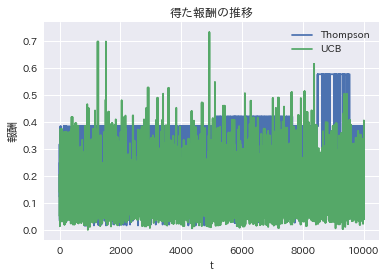

In [33]:
plt.plot(reward_ans1)
plt.plot(reward_ans2)
#plt.plot(epsilon_rewards)

plt.legend(['Thompson', 'UCB'], loc='best')
plt.xlabel('t')
plt.ylabel(u'報酬')
plt.title(u'得た報酬の推移')

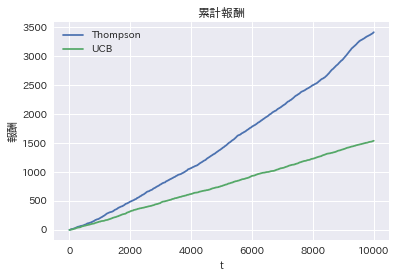

In [34]:
plt.plot(rewards1.cumsum())
plt.plot(rewards2.cumsum())
#plt.plot(epsilon_rewards)

plt.legend(['Thompson', 'UCB'], loc='best')
plt.xlabel('t')
plt.ylabel(u'報酬')
plt.title(u'累計報酬')

Thompson Samplingは途中から特定の腕しか引かなくなる

## 分散の確認

引かれる腕の回数がどれだけ偏るかを確認する

- UCB
- Thompson Sampling
- Thompson Sampling (AlphaとBetaの上昇率を抑えた物)

In [38]:
tests = 5000
arms = 50
alpha, beta = (1, 1)
strategy = ThompsonSamplingStrategy(alpha, beta, p=0.0001, arms=arms)
print('Start Thompson Samplig using alpha: %i, beta: %i' % (alpha, beta))
rewards1 = np.array([strategy.pull() for _ in range(tests)])
reward_ans1 = strategy.reward_history
pulled_count1 = list(map(lambda a: a.pulled_count, strategy.arms._arms))
armrewards1 = list(map(lambda a: a.reward, strategy.arms._arms))

strategy = ThompsonSamplingStrategy(alpha, beta, with_stop=True, p=0.0001, arms=arms)
print('Start Thompson Samplig with stop using alpha: %i, beta: %i' % (alpha, beta))
rewards2 = np.array([strategy.pull() for _ in range(tests)])
reward_ans2 = strategy.reward_history
pulled_count2 = list(map(lambda a: a.pulled_count, strategy.arms._arms))
armrewards2 = list(map(lambda a: a.reward, strategy.arms._arms))


strategy = UCB1Strategy(p=0.0001, arms=arms)
print('Start UCB')
rewards3 = np.array([strategy.pull() for _ in range(tests)])
reward_ans3 = strategy.reward_history
pulled_count3 = list(map(lambda a: a.pulled_count, strategy.arms._arms))
armrewards3 = list(map(lambda a: a.reward, strategy.arms._arms))
      

Start Thompson Samplig using alpha: 1, beta: 1
Start Thompson Samplig with stop using alpha: 1, beta: 1
Start UCB


In [39]:
print("Thompson Samplingの腕の分散 %f" % np.var(armrewards1))
print("制約付きThompson Samplingの腕の分散 %f" % np.var(armrewards2))
print("UCBの腕の分散 %f" % np.var(armrewards3))
# Thompson Samplingの腕の分散 0.009055
# 制約付きThompson Samplingの腕の分散 0.007380
# UCBの腕の分散 0.006541

Thompson Samplingの腕の分散 0.007891
制約付きThompson Samplingの腕の分散 0.009197
UCBの腕の分散 0.006681


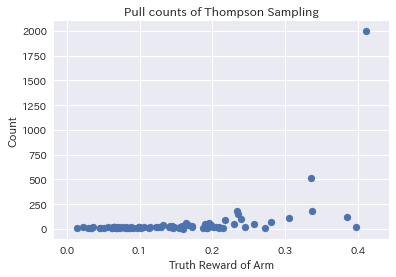

In [40]:
plt.scatter(armrewards1, pulled_count1)
plt.title(u'Pull counts of Thompson Sampling')
plt.xlabel('Truth Reward of Arm')
plt.ylabel('Count')

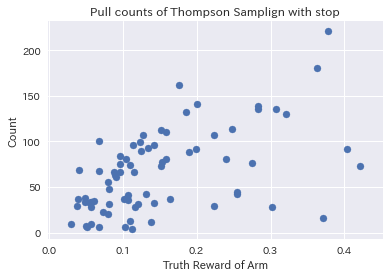

In [41]:
plt.scatter(armrewards2, pulled_count2)
plt.title(u'Pull counts of Thompson Samplign with stop')
plt.xlabel('Truth Reward of Arm')
plt.ylabel('Count')

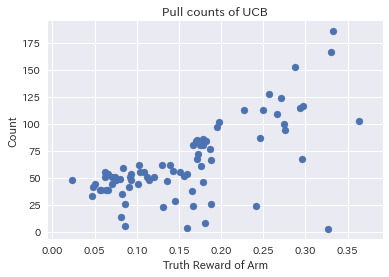

In [42]:
plt.scatter(armrewards3, pulled_count3)
plt.title(u'Pull counts of UCB')
plt.xlabel('Truth Reward of Arm')
plt.ylabel('Count')

Thompson Samplingは腕の推定報酬を返すベータ分布の $\alpha, \beta$ が大きくなると、腕の期待報酬の分散が小さくなり。期待報酬の少ない腕は全く引かれなくなる。

In [37]:
tests = 100000
arms = 100
alpha, beta = (1, 1)
strategy = ThompsonSamplingStrategy(alpha, beta, p=0.0001, arms=arms)
print('Start Thompson Samplig using alpha: %i, beta: %i' % (alpha, beta))
rewards1 = np.array([strategy.pull() for _ in range(tests)])
reward_ans1 = strategy.reward_history
pulled_count1 = list(map(lambda a: a.pulled_count, strategy.arms._arms))
armrewards1 = list(map(lambda a: a.reward, strategy.arms._arms))

strategy = ThompsonSamplingStrategy(alpha, beta, with_stop=True, p=0.0001, arms=arms)
print('Start Thompson Samplig with stop using alpha: %i, beta: %i' % (alpha, beta))
rewards2 = np.array([strategy.pull() for _ in range(tests)])
reward_ans2 = strategy.reward_history
pulled_count2 = list(map(lambda a: a.pulled_count, strategy.arms._arms))
armrewards2 = list(map(lambda a: a.reward, strategy.arms._arms))


strategy = UCB1Strategy(p=0.0001, arms=arms)
print('Start UCB')
rewards3 = np.array([strategy.pull() for _ in range(tests)])
reward_ans3 = strategy.reward_history
pulled_count3 = list(map(lambda a: a.pulled_count, strategy.arms._arms))
armrewards3 = list(map(lambda a: a.reward, strategy.arms._arms))
      

Start Thompson Samplig using alpha: 1, beta: 1
Start Thompson Samplig with stop using alpha: 1, beta: 1
Start UCB


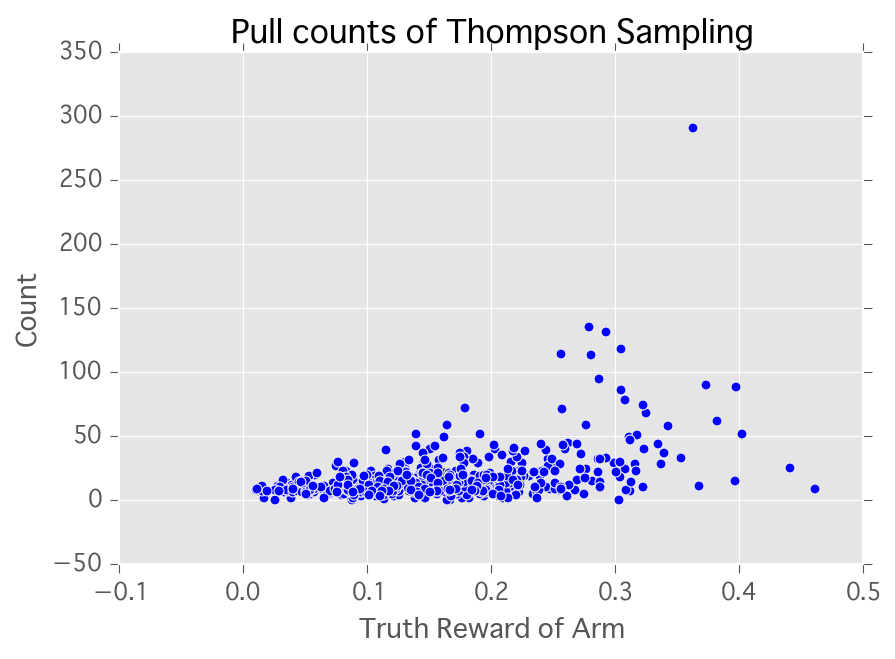

In [201]:
plt.scatter(armrewards1, pulled_count1)
plt.title(u'Pull counts of Thompson Sampling')
plt.xlabel('Truth Reward of Arm')
plt.ylabel('Count')

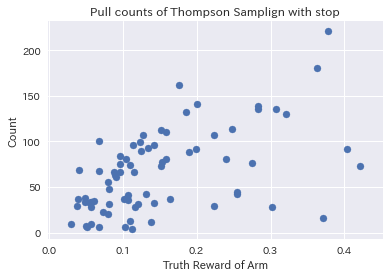

In [43]:
plt.scatter(armrewards2, pulled_count2)
plt.title(u'Pull counts of Thompson Samplign with stop')
plt.xlabel('Truth Reward of Arm')
plt.ylabel('Count')

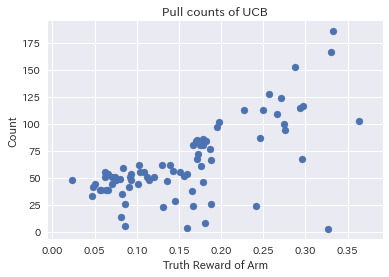

In [44]:
plt.scatter(armrewards3, pulled_count3)
plt.title(u'Pull counts of UCB')
plt.xlabel('Truth Reward of Arm')
plt.ylabel('Count')